In [4]:
import pandas as pd
import numpy as np
import json
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
import re
import spacy
import textstat
import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
def get_data():
    path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/reviews.json"
    df = pd.read_json(path, lines=True)

    pos_path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/positive-words.txt"
    neg_path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/negative-words.txt"

    pos = pd.read_csv(pos_path, sep="\n", header=None, encoding='latin-1')
    neg = pd.read_csv(neg_path, sep="\n", header=None, encoding='latin-1')

    pos_words = np.array(pos[0]).tolist()
    neg_words = np.array(neg[0]).tolist()
    
    return df, pos_words, neg_words


def data_preprocessing(df):
    df.helpful = df.helpful.str.split(" ").str.get(0)
    for i in range(0, len(df)):
        df["helpful"].iloc[i] = df["helpful"].iloc[i].replace(',', '')

    df["helpful"] = df["helpful"].replace(to_replace="One", value="1")
    df["helpful"] = df.helpful.astype(int)

    df['postDate'] = df['postDate'].apply(lambda x: ' '.join(x.split(' ')[4:]))

    df["postDate"] = pd.to_datetime(df["postDate"])

    df["reviewerLink"] = df.reviewerLink.astype(str)
    df["reviewerLink"] = "https://amazon.in" + df["reviewerLink"]
    
    df["nextPage"].iloc[0].split('/')

    product_name = df.nextPage.iloc[0].split('/')[1]
    
    df.nextPage = df.nextPage.str.split("&").str.get(0).str.get(-1)

    df["starRating"] = df.starRating.str.split(" ").str.get(0)
    df["starRating"] = df.starRating.astype(float)

    df.loc[df["starRating"]>3.0, "sentiment"] = 1
    df.loc[df["starRating"]<=3.0, "sentiment"] = 0

    df["sentiment"] = df.sentiment.astype(int)

    df.sort_values(by='postDate', inplace=True)

    df.drop(["verifiedPurchase"], axis=1, inplace=True)

    new_df = df
    
    return new_df, product_name


def remove_stopwords(rev):
    stop_words = stopwords.words('english')
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new


def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output


def data_cleaning(new_df):
    review_titles = new_df.reviewTitles
    review_body = new_df.reviewBody
    
    sample_df = new_df[["reviewBody", "reviewTitles"]]
    sample_df['reviewBody'] = sample_df['reviewBody'].str.replace("[^a-zA-Z#]", " ")
    sample_df['reviewBody'] = sample_df['reviewBody'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

    # remove stopwords from the text
    reviews = [remove_stopwords(r.split()) for r in sample_df['reviewBody']]

    # make entire text lowercase
    reviews = [r.lower() for r in reviews]
    
    
    tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
    
    reviews_2 = lemmatization(tokenized_reviews)
    
    for i in range(0, len(reviews_2)):
        for j in range(0,len(reviews_2[i])-1):
            reviews_2[i][j] = reviews_2[i][j] + " " + reviews_2[i][j+1]
    
    return reviews_2


def topics_list(reviews_2, pos_words, neg_words):
    dictionary = corpora.Dictionary(reviews_2)

    doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

    LDA = gensim.models.ldamodel.LdaModel

    lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=12, random_state=100, chunksize=1000, passes=50)
    
    topic_list = lda_model.print_topics()

    l = []
    for i in topic_list:
        l.append(i[1])

    lst = []
    for i in l:
        x = i.split("+")
        for j in x:
            y = j.split("*")
            lst.append(y)

    dic = {}
    for i in lst:
        topic = " ".join(re.split("[^a-zA-Z]*", i[1]))
        if(topic not in dic):
            dic[topic] = 1
            continue
        dic[topic] = dic[topic] + 1

    topics = []
    for i in dic:
        if(dic[i]>1):
            topics.append(i)
            
    final_topics = []
    for i in topics:
        l = i.split(" ")
        if(len(l)>3):
            if((l[1] in pos_words) or (l[2] in pos_words) or (l[1] in neg_words) or (l[2] in neg_words)):
                continue
        if((l[1] in pos_words) or (l[1] in neg_words)):
            continue
        final_topics.append(i.strip())
    
    return final_topics


def categorizing_reviews(new_df, final_topics):
    new_df["Categories"] = np.nan

    reviewers_link = new_df["reviewerLink"]

    new_df["Categories"] = new_df["Categories"].astype(object)

    for j in range(0, len(new_df)):
        l = []
        for i in final_topics:
            if(i not in new_df["reviewBody"].iloc[j].lower()):
                continue
            l.append(i)
        new_df["Categories"].iloc[j] = l
    
    return new_df


def readibility_score(txt):
    return textstat.dale_chall_readability_score(txt)


def final_data_cleaning(new_df):
    new_df["reviewLength"] = np.nan

    for i in range(0, len(new_df)):
        new_df["reviewLength"].iloc[i] = len(new_df["reviewBody"].iloc[i].split(" "))

    new_df["reviewLength"] = new_df["reviewLength"].astype(int)
    
    new2_df = new_df

    new2_df = new2_df.drop(new2_df[(len(new2_df["Categories"])==0) or (new2_df["reviewLength"]<15)].index)

    new2_df.sort_values("helpful", axis = 0, ascending = False, inplace = True, na_position ='last')
    
    new2_df["noOfCategories"] = np.nan

    for i in range(0, len(new2_df)):
        new2_df["noOfCategories"].iloc[i] = len(new2_df["Categories"].iloc[i])

    new2_df["noOfCategories"] = new2_df.noOfCategories.astype(int)
    new2_df.sort_values(by="noOfCategories", axis = 0, ascending = False, inplace = True, na_position ='last')
    
    new2_df["Page"] = np.nan
    new2_df["nextPage"] = new2_df.nextPage.astype(int)
    for i in range(0, len(new2_df)):
        new2_df["Page"].iloc[i] = new2_df["nextPage"].iloc[i] - 1
    new2_df["Page"] = new2_df.Page.astype(int)
    new2_df.drop(['nextPage'], axis = 1, inplace=True)
    
    new2_df["readingScore"] = np.nan
    new2_df["readingScore"] = new2_df["readingScore"].astype(float)

    for i in range(0,len(new2_df)):
        txt = new2_df["reviewBody"].iloc[i]
        new2_df.readingScore.iloc[i] = readibility_score(txt)
    
    new2_df["finalScore"] = np.nan
    new_2df["finalScore"] = new2_df["finalScore"].astype(float)

    for i in range(0, len(new2_df)):
        new2_df.finalScore.iloc[i] = ((0.40*output_data["reviewLength"].iloc[i]) + (0.40*output_data["noOfCategories"].iloc[i]) + (0.05*output_data["readingScore"].iloc[i]) + (0.15*output_data["helpful"].iloc[i]))

    
    return new2_df

def review_count(new_df):
    review_dic = [["Review", "Count"], ["1 Star", 0], ["2 Star", 0], ["3 Star", 0], ["4 Star", 0], ["5 Star", 0]]
    for i in range(0,len(new_df)):
        x = new_df["starRating"].iloc[i]
        review_dic[int(x)][1] = review_dic[int(x)][1] + 1
    return review_dic

In [20]:
df, pos_words, neg_words = get_data()
new_df, product_name = data_preprocessing(df)
reviews_2 = data_cleaning(new_df)
final_topics = topics_list(reviews_2, pos_words, neg_words)
new_df = categorizing_reviews(new_df, final_topics)
output_data = final_data_cleaning(new_df)

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\HP\Anaconda2\envs\py35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)
C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [21]:
final_topics

['value money',
 'battery life',
 'wide angle',
 'phone',
 'front camera',
 'phone camera',
 'oneplus pro',
 'oneplus phone',
 'battery backup',
 'full screen',
 'finger print',
 'dolby atmo',
 'camera quality']

In [5]:
new_df.head()

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength
154,1,Pravasini panda,3,2019-01-08,Looking good,Wow,https://amazon.in/gp/profile/amzn1.account.AHM...,5.0,1,[],2
10,22,Pratheek K,3,2019-01-13,Good quality👌🏻....,Best watch,https://amazon.in/gp/profile/amzn1.account.AHC...,5.0,1,[],2
20,6,Debojyoti Ghosh,4,2019-01-14,Very good watch. It's looks is amazing. And th...,Nice watch,https://amazon.in/gp/profile/amzn1.account.AG3...,5.0,1,[watch],19
18,8,rajan,3,2019-01-14,This is an awsm watch ..I got it in Only Rs200...,Redux Watch,https://amazon.in/gp/profile/amzn1.account.AFB...,5.0,1,[watch],17
13,10,Mayur,3,2019-01-14,This watch is so light weight as it feels like...,Worst product.,https://amazon.in/gp/profile/amzn1.account.AFM...,1.0,0,[watch],29


In [10]:
output_data.head(40)

,helpful,names,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,noOfCategories,Page,readingScore
238,1,Dr. Vishnu vardhan,2019-12-07,First set of one plus 7tpro maclaren had heati...,Don't expect much,https://amazon.in/gp/profile/amzn1.account.AFX...,2.0,0,"[wide angle, phone, front camera, finger print...",301,5,8,6.96
167,1,pankaj singh,2020-03-04,Finger print reader was much faster in one plu...,Oneplus user ..used all OnePlus models till date,https://amazon.in/gp/profile/amzn1.account.AEN...,5.0,1,"[battery life, phone, finger print, camera qua...",33,4,7,9.10
115,2,Rizwana,2019-11-25,It is really worth the price!The fast charging...,Well done One Plus!,https://amazon.in/gp/profile/amzn1.account.AGO...,5.0,1,"[battery life, phone, front camera, camera qua...",60,4,4,9.51
82,2,Akanksha,2019-11-26,The one plus should be serious now on camera s...,go for it in this price else wait for oneplus ...,https://amazon.in/gp/profile/amzn1.account.AGF...,4.0,1,"[battery life, phone, battery backup, camera q...",74,4,-1,10.72
14,30,Deepak Kumar Tiwari,2019-10-24,Earlier I was one plus 5T That time i 100% Sat...,Review after few Day Usage..,https://amazon.in/gp/profile/amzn1.account.AFV...,4.0,1,"[battery life, phone, battery backup]",758,3,2,13.28
72,1,Amazon Customer,2019-11-13,Yesterday i got my new phone one plus 7T macla...,Premium feel design,https://amazon.in/gp/profile/amzn1.account.AHP...,4.0,1,"[phone, front camera, full screen]",131,3,8,7.42
77,1,Sri Phani,2019-10-25,Am a lover of Samsung phones. I saw this 7pro ...,The best DISPLAY & GRAPHIC ORIENTED smart phon...,https://amazon.in/gp/profile/amzn1.account.AFY...,5.0,1,"[phone, finger print, dolby atmo]",108,3,8,9.08
63,1,Abhishek kumar,2019-11-26,This review is written after using OnePlus 7t ...,Best value for money,https://amazon.in/gp/profile/amzn1.account.AEC...,5.0,1,"[phone, battery backup, full screen]",155,3,7,7.29
245,1,Amol,2020-02-29,This one is my third oneplus phone earlier bei...,The best of all oneplus devices,https://amazon.in/gp/profile/amzn1.account.AFT...,4.0,1,"[battery life, phone, oneplus phone]",73,3,0,6.52
44,4,Ameesh Bisaria,2019-10-22,A review from a buyer switching from 1+ 5 to 7...,"Quality product, battery n camera could have b...",https://amazon.in/gp/profile/amzn1.account.AHL...,4.0,1,"[battery life, phone, full screen]",259,3,5,7.81


C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
output_data.head(20)

,helpful,names,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,noOfCategories,Page,readingScore,finalScore
238,1,Dr. Vishnu vardhan,2019-12-07,First set of one plus 7tpro maclaren had heati...,Don't expect much,https://amazon.in/gp/profile/amzn1.account.AFX...,2.0,0,"[wide angle, phone, front camera, finger print...",301,5,8,6.96,138.396
167,1,pankaj singh,2020-03-04,Finger print reader was much faster in one plu...,Oneplus user ..used all OnePlus models till date,https://amazon.in/gp/profile/amzn1.account.AEN...,5.0,1,"[battery life, phone, finger print, camera qua...",33,4,7,9.10,17.560
115,2,Rizwana,2019-11-25,It is really worth the price!The fast charging...,Well done One Plus!,https://amazon.in/gp/profile/amzn1.account.AGO...,5.0,1,"[battery life, phone, front camera, camera qua...",60,4,4,9.51,29.751
82,2,Akanksha,2019-11-26,The one plus should be serious now on camera s...,go for it in this price else wait for oneplus ...,https://amazon.in/gp/profile/amzn1.account.AGF...,4.0,1,"[battery life, phone, battery backup, camera q...",74,4,-1,10.72,36.172
14,30,Deepak Kumar Tiwari,2019-10-24,Earlier I was one plus 5T That time i 100% Sat...,Review after few Day Usage..,https://amazon.in/gp/profile/amzn1.account.AFV...,4.0,1,"[battery life, phone, battery backup]",758,3,2,13.28,343.778
72,1,Amazon Customer,2019-11-13,Yesterday i got my new phone one plus 7T macla...,Premium feel design,https://amazon.in/gp/profile/amzn1.account.AHP...,4.0,1,"[phone, front camera, full screen]",131,3,8,7.42,61.042
77,1,Sri Phani,2019-10-25,Am a lover of Samsung phones. I saw this 7pro ...,The best DISPLAY & GRAPHIC ORIENTED smart phon...,https://amazon.in/gp/profile/amzn1.account.AFY...,5.0,1,"[phone, finger print, dolby atmo]",108,3,8,9.08,50.858
63,1,Abhishek kumar,2019-11-26,This review is written after using OnePlus 7t ...,Best value for money,https://amazon.in/gp/profile/amzn1.account.AEC...,5.0,1,"[phone, battery backup, full screen]",155,3,7,7.29,71.829
245,1,Amol,2020-02-29,This one is my third oneplus phone earlier bei...,The best of all oneplus devices,https://amazon.in/gp/profile/amzn1.account.AFT...,4.0,1,"[battery life, phone, oneplus phone]",73,3,0,6.52,34.852
44,4,Ameesh Bisaria,2019-10-22,A review from a buyer switching from 1+ 5 to 7...,"Quality product, battery n camera could have b...",https://amazon.in/gp/profile/amzn1.account.AHL...,4.0,1,"[battery life, phone, full screen]",259,3,5,7.81,118.681


In [18]:
output_data.sort_values("finalScore", axis = 0, ascending = False, inplace = True, na_position ='last')

In [19]:
output_data.head(20)

,helpful,names,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,noOfCategories,Page,readingScore,finalScore
1,463,Rinse John,2019-10-16,==== A lengthy & brutally honest review. It's ...,The Best Smartphone of 2019 | The Flagship King,https://amazon.in/gp/profile/amzn1.account.AEL...,5.0,1,"[wide angle, phone]",913,2,1,7.51,435.8255
58,1,Shail Barot,2019-12-23,This is going to be a long review so if you ar...,Why wouldn't you buy this?,https://amazon.in/gp/profile/amzn1.account.AER...,4.0,1,"[phone, full screen, dolby atmo]",793,3,6,6.49,318.8745
14,30,Deepak Kumar Tiwari,2019-10-24,Earlier I was one plus 5T That time i 100% Sat...,Review after few Day Usage..,https://amazon.in/gp/profile/amzn1.account.AFV...,4.0,1,"[battery life, phone, battery backup]",758,3,2,13.28,309.5640
48,2,Pratik,2020-01-11,I am writing this review after 2 months of usa...,A Premium Beast with Class,https://amazon.in/gp/profile/amzn1.account.AGZ...,5.0,1,"[wide angle, phone, battery backup]",475,3,5,6.52,191.8260
61,2,Harshal D,2019-11-10,Pros -1) Specs - absolutely top notch2) Softwa...,Honest review - Beauty and the beast together!,https://amazon.in/gp/profile/amzn1.account.AFG...,5.0,1,[phone],458,1,7,6.92,184.2460
0,593,BunnyDecoder,2019-10-15,I think I am the first one to write a review f...,Its a complete Beast !!! Awesome mobile,https://amazon.in/gp/profile/amzn1.account.AGR...,5.0,1,"[phone, battery backup]",203,2,1,6.74,171.2870
42,3,Sangamesh Hiremath,2019-11-16,Guys..It's an awesome phone when you look at i...,If you're an average user then read this. Awes...,https://amazon.in/gp/profile/amzn1.account.AGI...,5.0,1,[phone],416,1,5,6.45,167.5725
5,101,Abirami,2019-10-17,Amazing phone with an unbelievably smooth and ...,Perfect combination of OnePlus 7T and 7Pro,https://amazon.in/gp/profile/amzn1.account.AGB...,5.0,1,[phone],314,1,1,8.91,141.5955
238,1,Dr. Vishnu vardhan,2019-12-07,First set of one plus 7tpro maclaren had heati...,Don't expect much,https://amazon.in/gp/profile/amzn1.account.AFX...,2.0,0,"[wide angle, phone, front camera, finger print...",301,5,8,6.96,122.8980
44,4,Ameesh Bisaria,2019-10-22,A review from a buyer switching from 1+ 5 to 7...,"Quality product, battery n camera could have b...",https://amazon.in/gp/profile/amzn1.account.AHL...,4.0,1,"[battery life, phone, full screen]",259,3,5,7.81,105.7905


In [30]:
output_data

'{"15":{"helpful":10,"names":"dinesh nagda","postDate":1567468800000,"reviewBody":"Infinity Glide 500 is very accurate in terms of sound quality. Build quality seems to be not so good because all is plastic. I was comparing this with Jbl T460 bluetooth headphone. The INFINITY GLIDE 500 is having puncy bass. I could say that bass is little bit overpowering...there is option to switch ON the deep base mode but believe me friends I could never feel the need to enable deep base mode. The bass is too much even in normal mode. So bass lovers will like this headphone for sure. Please allow some time to burn the headphone to produce quality sound. First day you may not feel the headphone good but believe me from second day I was just in love with this as it produces sharp details. So burning time is required to free up the components of headphone. Battery backup is tremendous...as compared to Jbl T460. Jbl T460 has just 11 hours whereas this headphone has 20 hours backup. Price is also very lo

In [15]:
final_topics

['objective que',
 'mid level',
 'cbse multiple',
 'entrance exam',
 'exam book',
 'que medical',
 'board student',
 'level objective',
 'medical aspirant',
 'engineering entrance',
 'product']

In [368]:
path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/reviews.json"

In [369]:
df = pd.read_json(path, lines=True)

pos_path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/positive-words.txt"
neg_path = "C:/Users/HP/Desktop/FILTER/amazon_reviews_scraping/negative-words.txt"

pos = pd.read_csv(pos_path, sep="\n", header=None, encoding='latin-1')
neg = pd.read_csv(neg_path, sep="\n", header=None, encoding='latin-1')

pos_words = np.array(pos[0]).tolist()
neg_words = np.array(neg[0]).tolist()

In [370]:
df.helpful = df.helpful.str.split(" ").str.get(0)

df["helpful"] = df["helpful"].replace(to_replace="One", value="1")
df["helpful"] = df.helpful.astype(int)

df['postDate'] = df['postDate'].apply(lambda x: ' '.join(x.split(' ')[4:]))

df["postDate"] = pd.to_datetime(df["postDate"])

df["reviewerLink"] = df.reviewerLink.astype(str)
df["reviewerLink"] = "https://amazon.in" + df["reviewerLink"]

In [371]:
df["nextPage"].iloc[0].split('/')

product_name = df.nextPage.iloc[0].split('/')[1]

print(product_name)

Rockerz-450-Wireless-Bluetooth-Headphone


In [372]:
df.nextPage = df.nextPage.str.split("&").str.get(0).str.get(-1)

df["starRating"] = df.starRating.str.split(" ").str.get(0)
df["starRating"] = df.starRating.astype(float)

df.loc[df["starRating"]>3.0, "sentiment"] = 1
df.loc[df["starRating"]<=3.0, "sentiment"] = 0

df["sentiment"] = df.sentiment.astype(int)

df.sort_values(by='postDate', inplace=True)

df.drop(["verifiedPurchase"], axis=1, inplace=True)

new_df = df

In [373]:
review_titles = new_df.reviewTitles
review_body = new_df.reviewBody

In [374]:
sample_df = new_df[["reviewBody", "reviewTitles"]]

In [375]:
sample_df.head()

,reviewBody,reviewTitles
2,This is a premium quality product from boAt-Li...,PLUG INTO NIRVANA
1,These are super comfortable and premium lookin...,Premium look and super comfy
9,All of thing is good but one thing is not good...,Aux cable
5,THREE MAIN DEMERITS👎 NOISE CANCELATION 0% PROD...,HEAVY HEADPHONE
0,I've owned boat products such as the Rockerz 4...,Best ever offering from boat but still a few p...


In [376]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

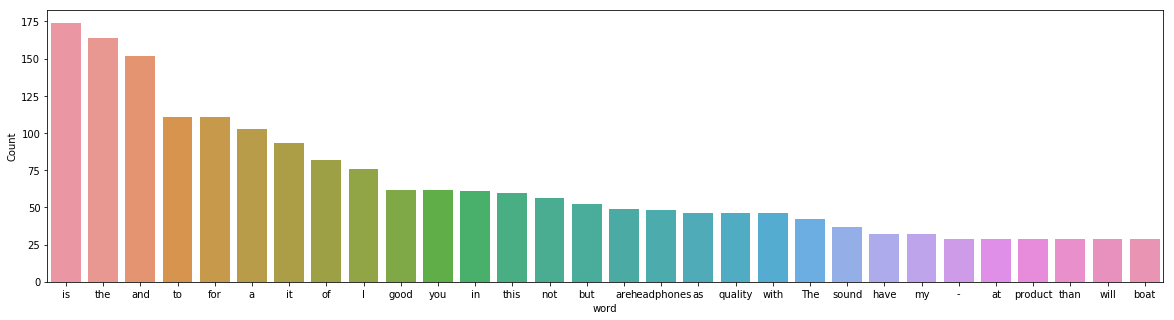

In [377]:
freq_words(sample_df['reviewBody'])

In [378]:
sample_df['reviewBody'] = sample_df['reviewBody'].str.replace("[^a-zA-Z#]", " ")

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [379]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [380]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
sample_df['reviewBody'] = sample_df['reviewBody'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in sample_df['reviewBody']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


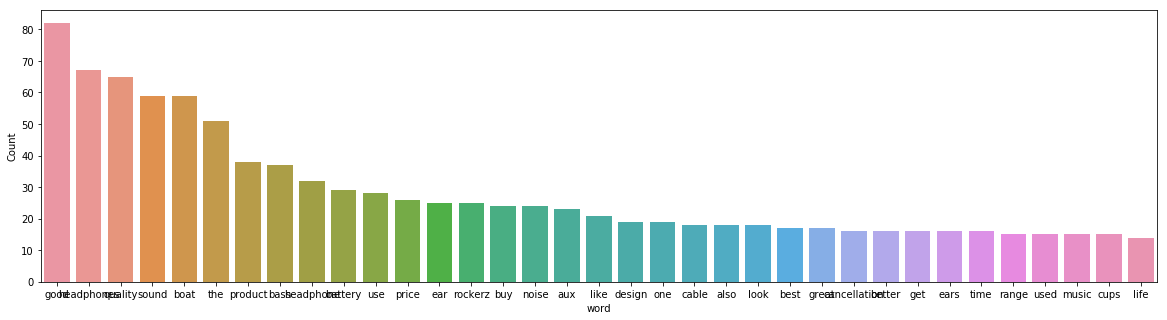

In [381]:
freq_words(reviews, 35)

In [382]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [383]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [384]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'super', 'comfortable', 'premium', 'looking', 'headphones', 'beautifully', 'designed', 'good', 'matt', 'finishing', 'sound', 'quality', 'top', 'notch', 'good', 'pop', 'songs', 'bass', 'good', 'enough', 'provide', 'decent', 'effect', 'ratings', 'sound', 'quality', 'durability', 'bass', 'material', 'quality', 'look', 'feel', 'bluetooth', 'noise', 'cancellation', 'battery', 'cons', 'aux', 'cable', 'provided', 'headphones', 'tell', 'difference', 'wires']


In [385]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['super', 'comfortable', 'premium', 'headphone', 'good', 'matt', 'sound', 'quality', 'top', 'notch', 'good', 'pop', 'song', 'good', 'decent', 'effect', 'rating', 'quality', 'durability', 'bass', 'material', 'quality', 'bluetooth', 'noise', 'cancellation', 'battery', 'con', 'cable', 'headphone', 'difference', 'wire']


In [386]:
reviews_2

[['premium',
  'quality',
  'product',
  'boat',
  'lifestyle',
  'professional',
  'grade',
  'driver',
  'music',
  'nirvana',
  'professional',
  'fine',
  'finish',
  'amazing',
  'battery',
  'life',
  'charge',
  'time',
  'marathon',
  'runner',
  'ear',
  'cushion',
  'comfy',
  'experience',
  'sound',
  'quality',
  'fabulous',
  'pain',
  'ear',
  'easy',
  'fold',
  'inward',
  'side',
  'easy',
  'safe',
  'table',
  'awesome',
  'product'],
 ['super',
  'comfortable',
  'premium',
  'headphone',
  'good',
  'matt',
  'sound',
  'quality',
  'top',
  'notch',
  'good',
  'pop',
  'song',
  'good',
  'decent',
  'effect',
  'rating',
  'quality',
  'durability',
  'bass',
  'material',
  'quality',
  'bluetooth',
  'noise',
  'cancellation',
  'battery',
  'con',
  'cable',
  'headphone',
  'difference',
  'wire'],
 ['thing', 'good', 'thing', 'good', 'cable', 'box'],
 ['main',
  'demerit',
  'cancelation',
  'product',
  'heavy',
  'aux',
  'cable',
  'boat',
  'rocker',
  

In [387]:
for i in range(0, len(reviews_2)):
    for j in range(0,len(reviews_2[i])-1):
        reviews_2[i][j] = reviews_2[i][j] + " " + reviews_2[i][j+1]

In [388]:
reviews_2

[['premium quality',
  'quality product',
  'product boat',
  'boat lifestyle',
  'lifestyle professional',
  'professional grade',
  'grade driver',
  'driver music',
  'music nirvana',
  'nirvana professional',
  'professional fine',
  'fine finish',
  'finish amazing',
  'amazing battery',
  'battery life',
  'life charge',
  'charge time',
  'time marathon',
  'marathon runner',
  'runner ear',
  'ear cushion',
  'cushion comfy',
  'comfy experience',
  'experience sound',
  'sound quality',
  'quality fabulous',
  'fabulous pain',
  'pain ear',
  'ear easy',
  'easy fold',
  'fold inward',
  'inward side',
  'side easy',
  'easy safe',
  'safe table',
  'table awesome',
  'awesome product',
  'product'],
 ['super comfortable',
  'comfortable premium',
  'premium headphone',
  'headphone good',
  'good matt',
  'matt sound',
  'sound quality',
  'quality top',
  'top notch',
  'notch good',
  'good pop',
  'pop song',
  'song good',
  'good decent',
  'decent effect',
  'effect rat

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


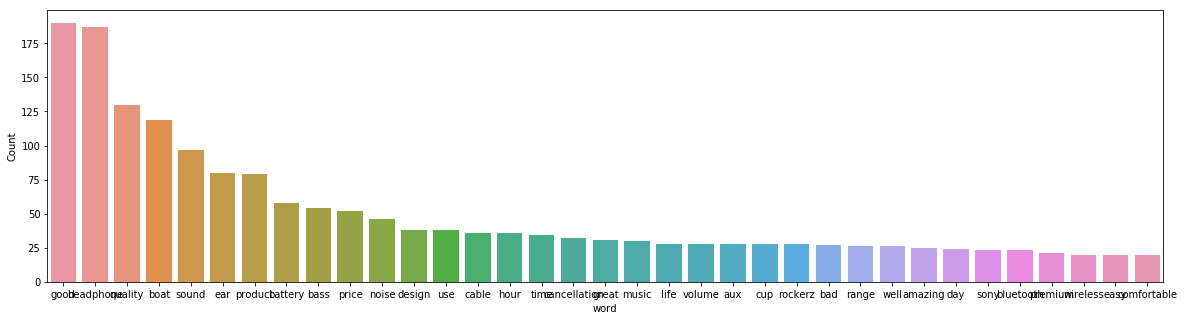

In [389]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

sample_df['reviews'] = reviews_3

freq_words(sample_df['reviews'], 35)

In [390]:
dictionary = corpora.Dictionary(reviews_2)

doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=12, random_state=100, chunksize=1000, passes=50)

lda_model.print_topics()

[(0,
  '0.010*"battery life" + 0.008*"sound quality" + 0.005*"good thing" + 0.005*"wireless headphone" + 0.005*"world wireless" + 0.005*"many people" + 0.005*"product boat" + 0.005*"boat" + 0.003*"price point" + 0.003*"headphone anything"'),
 (1,
  '0.004*"quality good" + 0.004*"first time" + 0.004*"boat headphone" + 0.004*"battery life" + 0.004*"day use" + 0.004*"phone position" + 0.004*"life well" + 0.004*"position boat" + 0.004*"good experience" + 0.004*"ear base"'),
 (2,
  '0.007*"aux cable" + 0.007*"battery life" + 0.007*"sound quality" + 0.005*"ear cushion" + 0.005*"quality product" + 0.005*"quality headphone" + 0.005*"price range" + 0.005*"experience sound" + 0.005*"ear cup" + 0.005*"festival sale"'),
 (3,
  '0.005*"good product" + 0.005*"little bit" + 0.005*"product amazon" + 0.005*"max volume" + 0.003*"connection blue" + 0.003*"boat last" + 0.003*"discomfort boat" + 0.003*"value money" + 0.003*"slight high" + 0.003*"less discomfort"'),
 (4,
  '0.012*"sound quality" + 0.008*"pr

In [391]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      13.680552        1       1  0.109332  0.108480
6      12.748906        1       2  0.079988 -0.136448
10     12.238818        1       3  0.038416  0.073534
0      11.496925        1       4 -0.000312 -0.094934
3      11.241627        1       5 -0.181958  0.011139
7       9.607746        1       6 -0.031251  0.052656
11      6.274855        1       7  0.003767 -0.004383
5       5.571157        1       8  0.016369 -0.009815
4       5.423499        1       9 -0.001377 -0.004438
1       5.185851        1      10 -0.007426  0.009473
9       4.668324        1      11 -0.019962 -0.005836
8       1.861748        1      12 -0.005585  0.000572, topic_info=     Category       Freq                  Term      Total  loglift  logprob
term                                                                       
1380  Default  20.000000         sound quality  20.000000  30.0000  30.0000
1438  Default   7.000000    noise cancellation   7.000000  29.0000  29.0000
1701  Default   5.000000        good headphone   5.000000  28.0000  28.0000
1403  Default   8.000000          battery life   8.000000  27.0000  27.0000
595   Default   6.000000             aux cable   6.000000  26.0000  26.0000
798   Default   4.000000    wireless headphone   4.000000  25.0000  25.0000
875   Default   3.000000        initial design   3.000000  24.0000  24.0000
42    Default   3.000000            good sound   3.000000  23.0000  23.0000
1398  Default   3.000000        headphone good   3.000000  22.0000  22.0000
648   Default   2.000000            good thing   2.000000  21.0000  21.0000
666   Default   2.000000             cable box   2.000000  20.0000  20.0000
1012  Default   2.000000           boat rocker   2.000000  19.0000  19.0000
425   Default   4.000000           price range   4.000000  18.0000  18.0000
1010  Default   5.000000          boat rockerz   5.000000  17.0000  17.0000
1785  Default   1.000000     quality bluetooth   1.000000  16.0000  16.0000
609   Default   0.000000            thing good   0.000000  15.0000  15.0000
895   Default   2.000000        battery backup   2.000000  14.0000  14.0000
604   Default   2.000000             nice bass   2.000000  13.0000  13.0000
190   Default   2.000000        sony headphone   2.000000  12.0000  12.0000
568   Default   1.000000           vocal music   1.000000  11.0000  11.0000
1294  Default   3.000000               ear cup   3.000000  10.0000  10.0000
641   Default   1.000000         price product   1.000000   9.0000   9.0000
1437  Default   1.000000                   box   1.000000   8.0000   8.0000
1019  Default   1.000000     premium headphone   1.000000   7.0000   7.0000
504   Default   4.000000     quality headphone   4.000000   6.0000   6.0000
1301  Default   1.000000          playing song   1.000000   5.0000   5.0000
1724  Default   1.000000        music listener   1.000000   4.0000   4.0000
1577  Default   3.000000                  boat   3.000000   3.0000   3.0000
1778  Default   1.000000         build quality   1.000000   2.0000   2.0000
991   Default   2.000000       headphone price   2.000000   1.0000   1.0000
...       ...        ...                   ...        ...      ...      ...
903   Topic12   0.228212       cable headphone   0.719570   2.8353  -5.1586
1286  Topic12   0.228212       durability bass   0.719570   2.8353  -5.1586
32    Topic12   0.228212           battery con   0.719570   2.8353  -5.1586
126   Topic12   0.228212     super comfortable   0.719570   2.8353  -5.1586
1149  Topic12   0.228212             song good   0.719570   2.8353  -5.1586
1211  Topic12   0.228212              pop song   0.719570   2.8353  -5.1586
1220  Topic12   0.228212       difference wire   0.719570   2.8353  -5.1586
780   Topic12   0.228212         bass material   0.719570   2.8353  -5.1586
737   Topic12   0.228212  headphone difference   0.719570   2.8353  -5.1586
1354  Top

In [392]:
topic_list = lda_model.print_topics()

l = []
for i in topic_list:
    l.append(i[1])

lst = []
for i in l:
    x = i.split("+")
    for j in x:
        y = j.split("*")
        lst.append(y)

dic = {}
for i in lst:
    topic = " ".join(re.split("[^a-zA-Z]*", i[1]))
    if(topic not in dic):
        dic[topic] = 1
        continue
    dic[topic] = dic[topic] + 1

topics = []
for i in dic:
    if(dic[i]>1):
        topics.append(i)

print(topics)

[' good headphone ', ' price range ', ' sound quality ', ' quality headphone ', ' quality bluetooth ', ' battery life ', ' headphone good ', ' wireless headphone ', ' battery backup ', ' noise cancellation ', ' boat rockerz ', ' aux cable ', ' quality good ', ' good sound ']


C:\Users\HP\Anaconda2\envs\py35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [393]:
print(dic)

{' initial design ': 1, ' value money ': 1, ' less bass ': 1, ' good headphone ': 2, ' vocal music ': 1, ' top notch ': 1, ' quality top ': 1, ' love star ': 1, ' good price ': 1, ' usage complete ': 1, ' good bass ': 1, ' month usage ': 1, ' ear cup ': 1, ' boat ': 1, ' life well ': 1, ' super comfortable ': 1, ' good bad ': 1, ' ear big ': 1, ' price product ': 1, ' headphone ear ': 1, ' price range ': 2, ' sound quality ': 7, ' boat rocker ': 1, ' quality product ': 1, ' mat finish ': 1, ' phone position ': 1, ' durability bass ': 1, ' use long ': 1, ' build quality ': 1, ' quality superb ': 1, ' price point ': 1, ' world wireless ': 1, ' battery con ': 1, ' good experience ': 1, ' little bit ': 1, ' connection blue ': 1, ' max volume ': 1, ' ear cushion ': 1, ' quality headphone ': 2, ' song headphone ': 1, ' long hour ': 1, ' boat last ': 1, ' many people ': 1, ' quality bluetooth ': 2, ' battery life ': 6, ' well wired ': 1, ' time good ': 1, ' discomfort boat ': 1, ' audio laten

In [394]:
final_topics = []
for i in topics:
    l = i.split(" ")
    if(len(l)>3):
        if((l[1] in pos_words) or (l[2] in pos_words) or (l[1] in neg_words) or (l[2] in neg_words)):
            continue
    if((l[1] in pos_words) or (l[1] in neg_words)):
        continue
    final_topics.append(i.strip())

In [395]:
final_topics

['price range',
 'sound quality',
 'quality headphone',
 'quality bluetooth',
 'battery life',
 'wireless headphone',
 'battery backup',
 'boat rockerz',
 'aux cable']

In [396]:
new_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment
2,71,Jinnish Dalal,2,2019-04-24,This is a premium quality product from boAt-Li...,PLUG INTO NIRVANA,https://amazon.in/gp/profile/amzn1.account.AGG...,5.0,1
1,80,Helloworld,2,2019-04-26,These are super comfortable and premium lookin...,Premium look and super comfy,https://amazon.in/gp/profile/amzn1.account.AEH...,5.0,1
9,13,jitanshu saini,2,2019-04-30,All of thing is good but one thing is not good...,Aux cable,https://amazon.in/gp/profile/amzn1.account.AGV...,5.0,1
5,22,Ayush Kashyap,2,2019-04-30,THREE MAIN DEMERITS👎 NOISE CANCELATION 0% PROD...,HEAVY HEADPHONE,https://amazon.in/gp/profile/amzn1.account.AHL...,1.0,0
0,201,abhishek,2,2019-05-02,I've owned boat products such as the Rockerz 4...,Best ever offering from boat but still a few p...,https://amazon.in/gp/profile/amzn1.account.AGJ...,4.0,1
15,9,Amazon Customer,3,2019-05-05,Hopeless headphones. Absolutely no base and ev...,Worthless headphones with good looks,https://amazon.in/gp/profile/amzn1.account.AFE...,1.0,0
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1
8,11,Ria B.,2,2019-05-07,The mic of the headphones doesn’t seem to be g...,Not satisfactory,https://amazon.in/gp/profile/amzn1.account.AFY...,2.0,0
13,8,DOT,3,2019-05-08,This headphone is good for the price but Rocke...,Aint Good as RockerZ-510,https://amazon.in/gp/profile/amzn1.account.AH3...,4.0,1
48,1,Shivendra Tripathi,1,2019-05-08,Worth every penny,Best of all,https://amazon.in/gp/profile/amzn1.account.AGT...,5.0,1


In [397]:
new_df["Categories"] = np.nan

reviewers_link = new_df["reviewerLink"]

new_df["Categories"] = new_df["Categories"].astype(object)

for j in range(0, len(new_df)):
    l = []
    for i in final_topics:
        if(i not in new_df["reviewBody"].iloc[j].lower()):
            continue
        l.append(i)
    new_df["Categories"].iloc[j] = l

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [398]:
new_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories
2,71,Jinnish Dalal,2,2019-04-24,This is a premium quality product from boAt-Li...,PLUG INTO NIRVANA,https://amazon.in/gp/profile/amzn1.account.AGG...,5.0,1,"[sound quality, battery life]"
1,80,Helloworld,2,2019-04-26,These are super comfortable and premium lookin...,Premium look and super comfy,https://amazon.in/gp/profile/amzn1.account.AEH...,5.0,1,"[sound quality, aux cable]"
9,13,jitanshu saini,2,2019-04-30,All of thing is good but one thing is not good...,Aux cable,https://amazon.in/gp/profile/amzn1.account.AGV...,5.0,1,[aux cable]
5,22,Ayush Kashyap,2,2019-04-30,THREE MAIN DEMERITS👎 NOISE CANCELATION 0% PROD...,HEAVY HEADPHONE,https://amazon.in/gp/profile/amzn1.account.AHL...,1.0,0,[aux cable]
0,201,abhishek,2,2019-05-02,I've owned boat products such as the Rockerz 4...,Best ever offering from boat but still a few p...,https://amazon.in/gp/profile/amzn1.account.AGJ...,4.0,1,"[battery life, aux cable]"
15,9,Amazon Customer,3,2019-05-05,Hopeless headphones. Absolutely no base and ev...,Worthless headphones with good looks,https://amazon.in/gp/profile/amzn1.account.AFE...,1.0,0,[]
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]"
8,11,Ria B.,2,2019-05-07,The mic of the headphones doesn’t seem to be g...,Not satisfactory,https://amazon.in/gp/profile/amzn1.account.AFY...,2.0,0,[]
13,8,DOT,3,2019-05-08,This headphone is good for the price but Rocke...,Aint Good as RockerZ-510,https://amazon.in/gp/profile/amzn1.account.AH3...,4.0,1,[boat rockerz]
48,1,Shivendra Tripathi,1,2019-05-08,Worth every penny,Best of all,https://amazon.in/gp/profile/amzn1.account.AGT...,5.0,1,[]


In [399]:
print(new_df["Categories"].iloc[1])

print(new_df["reviewBody"].iloc[1])

['sound quality', 'aux cable']
These are super comfortable and premium looking headphones. Beautifully designed with very good matt finishing.Sound quality is top notch, good for pop songs. Bass is good enough to provide a decent effect.Ratings - 4.5/5Sound quality: 9.5/10Durability: 9.5/10Bass: 9/10Material quality: 10/10Look and feel: 10/10Bluetooth: 10/10Noise cancellation: 8.5/10Battery: 10/10Cons -Aux cable not provided with the headphones, so can't tell the difference with wires.


In [400]:
new_df.Categories

2                         [sound quality, battery life]
1                            [sound quality, aux cable]
9                                           [aux cable]
5                                           [aux cable]
0                             [battery life, aux cable]
15                                                   []
3            [price range, sound quality, battery life]
8                                                    []
13                                       [boat rockerz]
48                                                   []
12        [sound quality, quality headphone, aux cable]
11    [sound quality, battery backup, boat rockerz, ...
14                                      [sound quality]
26                                      [sound quality]
4         [sound quality, battery backup, boat rockerz]
32                                      [sound quality]
29                             [price range, aux cable]
51                                              

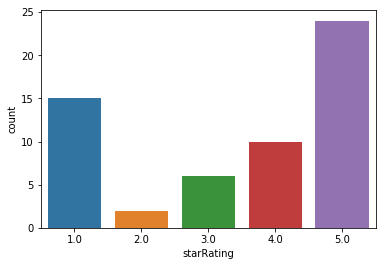

In [401]:
sns.countplot(x = new_df.starRating)

In [402]:
new_df["reviewLength"] = np.nan

for i in range(0, len(new_df)):
    new_df["reviewLength"].iloc[i] = len(new_df["reviewBody"].iloc[i].split(" "))

new_df["reviewLength"] = new_df["reviewLength"].astype(int)

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [403]:
new_df.describe()

,helpful,starRating,sentiment,reviewLength
count,57.000000,57.000000,57.000000,57.000000
mean,10.192982,3.456140,0.596491,108.052632
std,29.454831,1.669797,0.494962,110.314716
min,1.000000,1.000000,0.000000,3.000000
25%,1.000000,1.000000,0.000000,49.000000
50%,2.000000,4.000000,1.000000,67.000000
75%,6.000000,5.000000,1.000000,123.000000
max,201.000000,5.000000,1.000000,557.000000


In [404]:
new2_df = new_df

new2_df = new2_df.drop(new2_df[(len(new2_df["Categories"])==0) or (new2_df["reviewLength"]<15)].index)

new2_df.sort_values("helpful", axis = 0, ascending = False, inplace = True, na_position ='last') 

In [405]:
def readibility_score(txt):
    return textstat.dale_chall_readability_score(txt)

new2_df["reviewBody"].iloc[1]

new2_df["readingScore"] = np.nan
new2_df["readingScore"] = new2_df["readingScore"].astype(float)

for i in range(0,len(new2_df)):
    txt = new2_df["reviewBody"].iloc[i]
    new2_df.readingScore.iloc[i] = readibility_score(txt)

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [406]:
new2_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,readingScore
0,201,abhishek,2,2019-05-02,I've owned boat products such as the Rockerz 4...,Best ever offering from boat but still a few p...,https://amazon.in/gp/profile/amzn1.account.AGJ...,4.0,1,"[battery life, aux cable]",253,6.66
1,80,Helloworld,2,2019-04-26,These are super comfortable and premium lookin...,Premium look and super comfy,https://amazon.in/gp/profile/amzn1.account.AEH...,5.0,1,"[sound quality, aux cable]",61,10.16
2,71,Jinnish Dalal,2,2019-04-24,This is a premium quality product from boAt-Li...,PLUG INTO NIRVANA,https://amazon.in/gp/profile/amzn1.account.AGG...,5.0,1,"[sound quality, battery life]",97,7.26
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]",187,16.20
5,22,Ayush Kashyap,2,2019-04-30,THREE MAIN DEMERITS👎 NOISE CANCELATION 0% PROD...,HEAVY HEADPHONE,https://amazon.in/gp/profile/amzn1.account.AHL...,1.0,0,[aux cable],36,7.50
4,20,Abith ⛤,2,2019-06-04,⚫ SOUND QUALITY - Sound quality is amazing for...,BOAT ROCKERZ 450 ( 7/10 ),https://amazon.in/gp/profile/amzn1.account.AHA...,5.0,1,"[sound quality, battery backup, boat rockerz]",387,8.67
9,13,jitanshu saini,2,2019-04-30,All of thing is good but one thing is not good...,Aux cable,https://amazon.in/gp/profile/amzn1.account.AGV...,5.0,1,[aux cable],20,6.21
6,13,Mohitpreet singh,2,2019-12-16,Do not buy if you want a durable headphones th...,My headphones broke after 23 days(worst durabi...,https://amazon.in/gp/profile/amzn1.account.AHW...,1.0,0,[],68,5.92
8,11,Ria B.,2,2019-05-07,The mic of the headphones doesn’t seem to be g...,Not satisfactory,https://amazon.in/gp/profile/amzn1.account.AFY...,2.0,0,[],64,7.23
15,9,Amazon Customer,3,2019-05-05,Hopeless headphones. Absolutely no base and ev...,Worthless headphones with good looks,https://amazon.in/gp/profile/amzn1.account.AFE...,1.0,0,[],23,6.08


In [407]:
new2_df["reviewBody"].iloc[11]

'Recently ordered the product so after using it for about 6 hours constantly, here is my review in pros and cons.Pros▪Comfort level is better than jbl 450 and previous boat rockerz edition.▪nice bass and sound quality.▪premium matte finish.▪ conectivity is pretty fast and good.Cons▪sound quality could have been better. i mean bass is good balance is good but sound quality is above average.▪no aux cable.I majorly bought it for jogging so i will update about battery backup and perfomance of this headphone afterwards.Update: perfect pair of headphones for jogging. Battery backup of 7-8 hours easily. get you through 2 days easily if you are medium user.Edit: 8 months and its broken now. i loved these headphones 😥 and now broken. Poor plastic by Boat.'

In [408]:
new2_df["Categories"].iloc[11]

['sound quality', 'battery backup', 'boat rockerz', 'aux cable']

In [409]:
new2_df["noOfCategories"] = np.nan

for i in range(0, len(new2_df)):
    new2_df["noOfCategories"].iloc[i] = len(new2_df["Categories"].iloc[i])

new2_df["noOfCategories"] = new2_df.noOfCategories.astype(int)

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [410]:
new2_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,readingScore,noOfCategories
0,201,abhishek,2,2019-05-02,I've owned boat products such as the Rockerz 4...,Best ever offering from boat but still a few p...,https://amazon.in/gp/profile/amzn1.account.AGJ...,4.0,1,"[battery life, aux cable]",253,6.66,2
1,80,Helloworld,2,2019-04-26,These are super comfortable and premium lookin...,Premium look and super comfy,https://amazon.in/gp/profile/amzn1.account.AEH...,5.0,1,"[sound quality, aux cable]",61,10.16,2
2,71,Jinnish Dalal,2,2019-04-24,This is a premium quality product from boAt-Li...,PLUG INTO NIRVANA,https://amazon.in/gp/profile/amzn1.account.AGG...,5.0,1,"[sound quality, battery life]",97,7.26,2
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]",187,16.20,3
5,22,Ayush Kashyap,2,2019-04-30,THREE MAIN DEMERITS👎 NOISE CANCELATION 0% PROD...,HEAVY HEADPHONE,https://amazon.in/gp/profile/amzn1.account.AHL...,1.0,0,[aux cable],36,7.50,1
4,20,Abith ⛤,2,2019-06-04,⚫ SOUND QUALITY - Sound quality is amazing for...,BOAT ROCKERZ 450 ( 7/10 ),https://amazon.in/gp/profile/amzn1.account.AHA...,5.0,1,"[sound quality, battery backup, boat rockerz]",387,8.67,3
9,13,jitanshu saini,2,2019-04-30,All of thing is good but one thing is not good...,Aux cable,https://amazon.in/gp/profile/amzn1.account.AGV...,5.0,1,[aux cable],20,6.21,1
6,13,Mohitpreet singh,2,2019-12-16,Do not buy if you want a durable headphones th...,My headphones broke after 23 days(worst durabi...,https://amazon.in/gp/profile/amzn1.account.AHW...,1.0,0,[],68,5.92,0
8,11,Ria B.,2,2019-05-07,The mic of the headphones doesn’t seem to be g...,Not satisfactory,https://amazon.in/gp/profile/amzn1.account.AFY...,2.0,0,[],64,7.23,0
15,9,Amazon Customer,3,2019-05-05,Hopeless headphones. Absolutely no base and ev...,Worthless headphones with good looks,https://amazon.in/gp/profile/amzn1.account.AFE...,1.0,0,[],23,6.08,0


In [411]:
new2_df.sort_values(by="noOfCategories", axis = 0, ascending = False, inplace = True, na_position ='last')

In [412]:
new2_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,readingScore,noOfCategories
21,1,Abhishek Pawar,4,2020-01-23,I am using Sony Headphones for over 2 years no...,Detailed Review: compared with Sony headphones...,https://amazon.in/gp/profile/amzn1.account.AFJ...,5.0,1,"[price range, sound quality, wireless headphon...",365,5.93,5
11,8,Akshat,3,2019-05-11,Recently ordered the product so after using it...,Bang for the buck but quality is poor.,https://amazon.in/gp/profile/amzn1.account.AE5...,1.0,0,"[sound quality, battery backup, boat rockerz, ...",124,9.38,4
10,7,Gizmofreak Reviews,3,2019-08-22,The boAt Rockerz line is boAt's super cheap li...,Simply Awful,https://amazon.in/gp/profile/amzn1.account.AFR...,1.0,0,"[sound quality, battery life, wireless headpho...",557,6.30,4
40,3,shivam dubey,8,2020-01-23,I have used two boat products before and i rea...,"Great Bass, Good battery life",https://amazon.in/gp/profile/amzn1.account.AEA...,5.0,1,"[battery life, boat rockerz, aux cable]",88,8.33,3
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]",187,16.20,3
4,20,Abith ⛤,2,2019-06-04,⚫ SOUND QUALITY - Sound quality is amazing for...,BOAT ROCKERZ 450 ( 7/10 ),https://amazon.in/gp/profile/amzn1.account.AHA...,5.0,1,"[sound quality, battery backup, boat rockerz]",387,8.67,3
12,6,Jitin,3,2019-05-09,It's a good build quality headphones from boat...,Good headphone at 1400rs price bracket,https://amazon.in/gp/profile/amzn1.account.AED...,3.0,0,"[sound quality, quality headphone, aux cable]",123,7.33,3
36,2,Ashok,6,2019-09-13,The initial design of boAt Rockerz 450 was a b...,The updated design is downgraded,https://amazon.in/gp/profile/amzn1.account.AH6...,3.0,0,"[sound quality, battery life, boat rockerz]",119,6.74,3
7,7,AJAY ANAND,2,2019-09-30,"Rockerz 450 is my Second Headphone from boAt, ...","Plug into Nirvana - Good looking, Easy to carr...",https://amazon.in/gp/profile/amzn1.account.AE6...,4.0,1,"[sound quality, quality headphone, battery life]",317,8.31,3
18,2,Vaishnavi Gangurde,3,2020-01-22,The product is just amazing!! It comes in a go...,Superb!,https://amazon.in/gp/profile/amzn1.account.AHP...,5.0,1,"[sound quality, aux cable]",135,7.08,2


In [413]:
print(new2_df["reviewBody"].iloc[0])

print(new2_df["reviewBody"].iloc[1])

I am using Sony Headphones for over 2 years now, which were sufficiently good for me. They got damaged somehow, and new sony wireless headphones costed a whole lot than this headphone so I would've had to buy the wired ones, so went for boat. So I'll be comparing these with Sony wired headphones in the same price range (<2000) (believe me, I've used all variants/models)Pros:1. The look: The Black ones that I bought look sick. Fallen in love. If you're a black lover like me, go for boat rockerz 450 instead of 510!🖤2. Bluetooth: it works crisp. I get range in my whole room and even when I keep the phone in my room and go into another room. Excellent.3. Price: I got them at ₹1199 at Republic Day sale 2020. Worth it.4. Aux cable: They provided me the aux cable. Everybody has confusion whether they'll provide or not, but they did to me.5. Sound Quality : Decent. Nice bass. If you have been using earphones, you'll love these headphones.6. Noise cancellation: My Sony ones didn't have noise ca

In [414]:
print(new2_df["Categories"].iloc[0])

['price range', 'sound quality', 'wireless headphone', 'boat rockerz', 'aux cable']


In [415]:
print(new2_df["Categories"].iloc[8])

['sound quality', 'quality headphone', 'battery life']


In [416]:
print(dic)

{' initial design ': 1, ' value money ': 1, ' less bass ': 1, ' good headphone ': 2, ' vocal music ': 1, ' top notch ': 1, ' quality top ': 1, ' love star ': 1, ' good price ': 1, ' usage complete ': 1, ' good bass ': 1, ' month usage ': 1, ' ear cup ': 1, ' boat ': 1, ' life well ': 1, ' super comfortable ': 1, ' good bad ': 1, ' ear big ': 1, ' price product ': 1, ' headphone ear ': 1, ' price range ': 2, ' sound quality ': 7, ' boat rocker ': 1, ' quality product ': 1, ' mat finish ': 1, ' phone position ': 1, ' durability bass ': 1, ' use long ': 1, ' build quality ': 1, ' quality superb ': 1, ' price point ': 1, ' world wireless ': 1, ' battery con ': 1, ' good experience ': 1, ' little bit ': 1, ' connection blue ': 1, ' max volume ': 1, ' ear cushion ': 1, ' quality headphone ': 2, ' song headphone ': 1, ' long hour ': 1, ' boat last ': 1, ' many people ': 1, ' quality bluetooth ': 2, ' battery life ': 6, ' well wired ': 1, ' time good ': 1, ' discomfort boat ': 1, ' audio laten

In [417]:
print(final_topics)

['price range', 'sound quality', 'quality headphone', 'quality bluetooth', 'battery life', 'wireless headphone', 'battery backup', 'boat rockerz', 'aux cable']


In [419]:
new2_df.head(20)

,helpful,names,nextPage,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,readingScore,noOfCategories
21,1,Abhishek Pawar,4,2020-01-23,I am using Sony Headphones for over 2 years no...,Detailed Review: compared with Sony headphones...,https://amazon.in/gp/profile/amzn1.account.AFJ...,5.0,1,"[price range, sound quality, wireless headphon...",365,5.93,5
11,8,Akshat,3,2019-05-11,Recently ordered the product so after using it...,Bang for the buck but quality is poor.,https://amazon.in/gp/profile/amzn1.account.AE5...,1.0,0,"[sound quality, battery backup, boat rockerz, ...",124,9.38,4
10,7,Gizmofreak Reviews,3,2019-08-22,The boAt Rockerz line is boAt's super cheap li...,Simply Awful,https://amazon.in/gp/profile/amzn1.account.AFR...,1.0,0,"[sound quality, battery life, wireless headpho...",557,6.30,4
40,3,shivam dubey,8,2020-01-23,I have used two boat products before and i rea...,"Great Bass, Good battery life",https://amazon.in/gp/profile/amzn1.account.AEA...,5.0,1,"[battery life, boat rockerz, aux cable]",88,8.33,3
3,28,Gimmicer,2,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]",187,16.20,3
4,20,Abith ⛤,2,2019-06-04,⚫ SOUND QUALITY - Sound quality is amazing for...,BOAT ROCKERZ 450 ( 7/10 ),https://amazon.in/gp/profile/amzn1.account.AHA...,5.0,1,"[sound quality, battery backup, boat rockerz]",387,8.67,3
12,6,Jitin,3,2019-05-09,It's a good build quality headphones from boat...,Good headphone at 1400rs price bracket,https://amazon.in/gp/profile/amzn1.account.AED...,3.0,0,"[sound quality, quality headphone, aux cable]",123,7.33,3
36,2,Ashok,6,2019-09-13,The initial design of boAt Rockerz 450 was a b...,The updated design is downgraded,https://amazon.in/gp/profile/amzn1.account.AH6...,3.0,0,"[sound quality, battery life, boat rockerz]",119,6.74,3
7,7,AJAY ANAND,2,2019-09-30,"Rockerz 450 is my Second Headphone from boAt, ...","Plug into Nirvana - Good looking, Easy to carr...",https://amazon.in/gp/profile/amzn1.account.AE6...,4.0,1,"[sound quality, quality headphone, battery life]",317,8.31,3
18,2,Vaishnavi Gangurde,3,2020-01-22,The product is just amazing!! It comes in a go...,Superb!,https://amazon.in/gp/profile/amzn1.account.AHP...,5.0,1,"[sound quality, aux cable]",135,7.08,2


In [421]:
new2_df["Page"] = np.nan
new2_df["nextPage"] = new2_df.nextPage.astype(int)
for i in range(0, len(new2_df)):
    new2_df["Page"].iloc[i] = new2_df["nextPage"].iloc[i] - 1
new2_df["Page"] = new2_df.Page.astype(int)
new2_df.drop(['nextPage'], axis = 1, inplace=True)

C:\Users\HP\Anaconda2\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [422]:
new2_df.head(20)

,helpful,names,postDate,reviewBody,reviewTitles,reviewerLink,starRating,sentiment,Categories,reviewLength,readingScore,noOfCategories,Page
21,1,Abhishek Pawar,2020-01-23,I am using Sony Headphones for over 2 years no...,Detailed Review: compared with Sony headphones...,https://amazon.in/gp/profile/amzn1.account.AFJ...,5.0,1,"[price range, sound quality, wireless headphon...",365,5.93,5,3
11,8,Akshat,2019-05-11,Recently ordered the product so after using it...,Bang for the buck but quality is poor.,https://amazon.in/gp/profile/amzn1.account.AE5...,1.0,0,"[sound quality, battery backup, boat rockerz, ...",124,9.38,4,2
10,7,Gizmofreak Reviews,2019-08-22,The boAt Rockerz line is boAt's super cheap li...,Simply Awful,https://amazon.in/gp/profile/amzn1.account.AFR...,1.0,0,"[sound quality, battery life, wireless headpho...",557,6.30,4,2
40,3,shivam dubey,2020-01-23,I have used two boat products before and i rea...,"Great Bass, Good battery life",https://amazon.in/gp/profile/amzn1.account.AEA...,5.0,1,"[battery life, boat rockerz, aux cable]",88,8.33,3,7
3,28,Gimmicer,2019-05-07,These are the best you can get for the price o...,Awesome headphones @1399/- (lighting deal),https://amazon.in/gp/profile/amzn1.account.AGX...,5.0,1,"[price range, sound quality, battery life]",187,16.20,3,1
4,20,Abith ⛤,2019-06-04,⚫ SOUND QUALITY - Sound quality is amazing for...,BOAT ROCKERZ 450 ( 7/10 ),https://amazon.in/gp/profile/amzn1.account.AHA...,5.0,1,"[sound quality, battery backup, boat rockerz]",387,8.67,3,1
12,6,Jitin,2019-05-09,It's a good build quality headphones from boat...,Good headphone at 1400rs price bracket,https://amazon.in/gp/profile/amzn1.account.AED...,3.0,0,"[sound quality, quality headphone, aux cable]",123,7.33,3,2
36,2,Ashok,2019-09-13,The initial design of boAt Rockerz 450 was a b...,The updated design is downgraded,https://amazon.in/gp/profile/amzn1.account.AH6...,3.0,0,"[sound quality, battery life, boat rockerz]",119,6.74,3,5
7,7,AJAY ANAND,2019-09-30,"Rockerz 450 is my Second Headphone from boAt, ...","Plug into Nirvana - Good looking, Easy to carr...",https://amazon.in/gp/profile/amzn1.account.AE6...,4.0,1,"[sound quality, quality headphone, battery life]",317,8.31,3,1
18,2,Vaishnavi Gangurde,2020-01-22,The product is just amazing!! It comes in a go...,Superb!,https://amazon.in/gp/profile/amzn1.account.AHP...,5.0,1,"[sound quality, aux cable]",135,7.08,2,2
